In [2]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [4]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [5]:
dataset = get_dataset("m4_hourly", regenerate=True)

saving time-series into /home/gitpod/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /home/gitpod/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


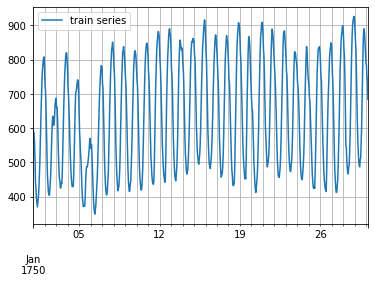

In [8]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

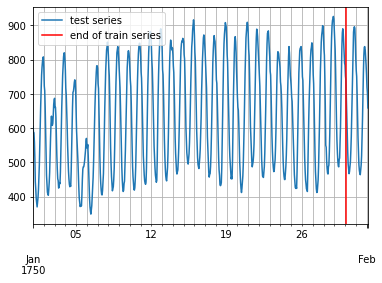

In [9]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [10]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


In [11]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

In [12]:
from gluonts.dataset.common import ListDataset

In [13]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{'target': x, 'start': start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{'target': x, 'start': start} for x in custom_dataset],
    freq=freq
)

In [14]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx.trainer import Trainer

In [15]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

In [16]:
predictor = estimator.train(dataset.train)

100%|██████████| 100/100 [00:01<00:00, 50.90it/s, epoch=5/5, avg_epoch_loss=4.69]


In [17]:
from gluonts.evaluation import make_evaluation_predictions

In [18]:

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [19]:

forecasts = list(forecast_it)
tss = list(ts_it)

In [20]:
# first entry of the time series list
ts_entry = tss[0]

# first entry of the forecast list
forecast_entry = forecasts[0]

In [21]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


In [22]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [614.48865 593.9952  523.73444 470.99255 548.7975  520.1584  460.47644
 492.13928 503.1581  533.3668  595.46185 704.55304 684.97174 836.03705
 848.17444 874.74133 822.44995 807.9968  858.8031  874.7127  723.5927
 833.2024  806.9908  774.83264 663.971   611.93304 556.64453 491.7391
 499.40363 597.92944 449.52    534.542   418.87323 527.9313  715.731
 739.9648  645.0835  823.7004  821.94257 898.00397 988.29956 926.29877
 859.7509  920.7188  848.2048  732.15845 736.2813  740.8362 ]
0.5-quantile (median) of the future window:
 [621.29944 585.77484 536.8809  474.4656  538.15564 525.2784  478.93857
 507.4865  509.53677 529.4135  594.42926 695.1219  710.56934 842.6693
 846.3662  881.6303  836.0855  821.8031  858.3308  891.7431  750.2552
 820.70416 806.13257 772.65845 668.79865 626.84906 556.52594 500.9157
 506.97784 600.4893  447.46542 522.6944  413.5265  521.3172  713.76373
 729.52496 623.7471  834.44836 824.6349  925.7505  980.3864  936.9785
 861.0749  882.25946 

In [23]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

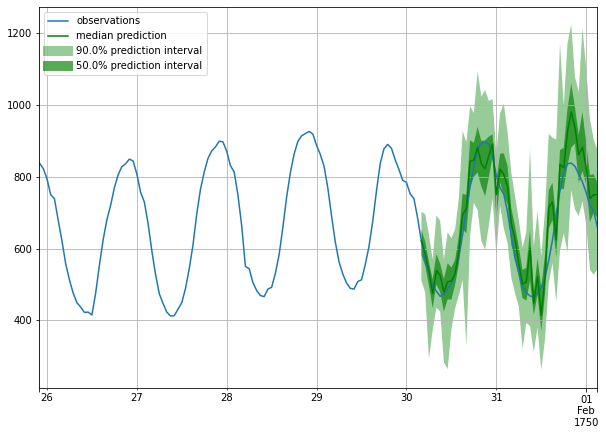

In [24]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [25]:
from gluonts.evaluation import Evaluator

In [26]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 2364.62it/s]


In [27]:

print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 14483061.916148895,
    "abs_error": 11745136.64202118,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 4.782135362589511,
    "MAPE": 0.26510404443875224,
    "sMAPE": 0.1990558618556666,
    "MSIS": 60.31706989640558,
    "QuantileLoss[0.1]": 4603931.49958067,
    "Coverage[0.1]": 0.12661030595813205,
    "QuantileLoss[0.5]": 11745136.70130825,
    "Coverage[0.5]": 0.544182769726248,
    "QuantileLoss[0.9]": 6868205.397298715,
    "Coverage[0.9]": 0.8770632045088566,
    "RMSE": 3805.6618236712648,
    "NRMSE": 0.5195568987679176,
    "ND": 0.08068994461463148,
    "wQuantileLoss[0.1]": 0.0316293448968162,
    "wQuantileLoss[0.5]": 0.08068994502193798,
    "wQuantileLoss[0.9]": 0.04718507157483158,
    "mean_absolute_QuantileLoss": 7739091.199395879,
    "mean_wQuantileLoss": 0.053168120497861925,
    "MAE_Coverage": 0.031243290391841178,
    "OWA": NaN
}


In [28]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,4104.717448,2355.029785,31644.0,659.250000,42.371302,1.157933,0.075024,0.071856,12.766568,871.955304,0.000000,2355.029907,0.791667,1430.189270,1.0000
1,1.0,209541.604167,19276.968750,124149.0,2586.437500,165.107988,2.432369,0.164110,0.147421,12.990772,5403.334009,0.395833,19276.968506,0.958333,8432.772803,1.0000
2,2.0,36735.901042,7045.859375,65030.0,1354.791667,78.889053,1.860698,0.101474,0.107502,12.462615,3259.832727,0.000000,7045.859192,0.187500,2781.076697,0.7500
3,3.0,262985.062500,18133.126953,235783.0,4912.145833,258.982249,1.458685,0.079122,0.079802,13.480108,9260.681250,0.062500,18133.126221,0.500000,8337.362598,0.9375
4,4.0,114652.072917,12463.384766,131088.0,2731.000000,200.494083,1.295070,0.095804,0.090473,11.864276,4518.300720,0.125000,12463.384277,0.666667,6822.530371,1.0000


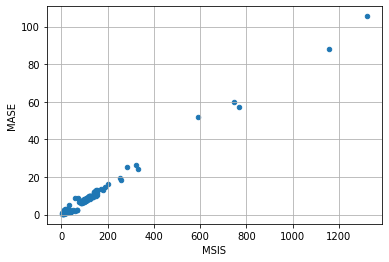

In [29]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()